In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
import torch
import torch.nn
import argparse
import os
import numpy as np
from options import HiDDenConfiguration

import utils
from model.hidden import *
from noise_layers.noiser import Noiser
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [2]:
base_path = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/"
device = torch.device('cuda:4')
device2 = torch.device('cuda:5')
message_length = 30

batch = 8

In [3]:
def load_hidden(options_file_path,checkpoint_file_path,device):
    train_options, hidden_config, noise_config = utils.load_options(options_file_path)
    noiser = Noiser(noise_config,device)
    checkpoint = torch.load(checkpoint_file_path,weights_only=True)
    hidden_net = Hidden(hidden_config, device, noiser, None)
    utils.model_from_checkpoint(hidden_net, checkpoint)
    return hidden_net.encoder_decoder.encoder, hidden_net.encoder_decoder.decoder



def load_fhat(source_image_path,batch):
    fhat = torch.load(source_image,weights_only=True)
    print("Original Tensor Shape:", fhat.shape)
    if fhat.dim() == 3:
        fhat.unsqueeze_(0)
    if fhat.dim() == 4 and fhat.shape[0] > 10:
        fhat = fhat[:batch]
    fhat = fhat.to(device)
    print("Original Tensor Shape:", fhat.shape)
    return fhat
    

In [4]:
def cal_error(decoded_message,message):

    decoded_rounded = decoded_message.detach().cpu().numpy().round().clip(0, 1)
    message_detached = message.detach().cpu().numpy()

    #print('error : {:.3f}'.format(np.mean(np.abs(decoded_rounded - message_detached))))

    bitwise_avg_err = np.sum(np.abs(decoded_rounded - message.detach().cpu().numpy()))/(fhat.shape[0] * message.shape[1])
    #print(f"bitwise_avg_err: {bitwise_avg_err}")

    return bitwise_avg_err

### Watermark

In [5]:
# encoded_images = hidden_net.encoder_decoder.encoder(i,m)
def add_watermark(image,message,hidden_encoder,device):
    message = message.to(device)
    image = image.to(device)
    encoded_image = hidden_encoder(image,message)
    return encoded_image


def get_watermark(image,hidden_decoder,device):
    image = image.to(device)
    decoded_message  = hidden_decoder(image)
    return decoded_message 

In [6]:
def repeat_test(test_func, num_trials=100):
    total_bitwise_avg_err = 0.0
    for i in range(num_trials):
        bitwise_avg_err = test_func()  
        total_bitwise_avg_err += bitwise_avg_err
    average_bitwise_avg_err = total_bitwise_avg_err / num_trials
    
    return average_bitwise_avg_err

## Method1
直接检测fhat，用于测试 embedding hidden 的 performance

使用 fhat 训练的 hidden_encoder

使用 fhat 训练的 hidden_decoder 



In [7]:
base_path = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/"
options_file = os.path.join(base_path,"options-and-config.pickle")
checkpoint_file =os.path.join(base_path,"checkpoints/watermark--epoch-300.pyt")
hidden_encoder,hidden_decoder = load_hidden(options_file,checkpoint_file,device)

source_image = os.path.join(base_path,"images/epoch-original-300.pt")
fhat = load_fhat(source_image,8)

Original Tensor Shape: torch.Size([64, 32, 16, 16])
Original Tensor Shape: torch.Size([8, 32, 16, 16])


In [8]:
def test_one_time1():
    message = torch.Tensor(np.random.choice([0, 1], (fhat.shape[0],message_length))).to(device)
    fhat_watermark = add_watermark(fhat,message,hidden_encoder,device)
    watermark = get_watermark(fhat_watermark,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()
    return bitwise_avg_err

test_one_time1()

0.02083333395421505

In [9]:
repeat_test(test_one_time1, num_trials=100)

0.01754166714847088

## Method2

- 使用 fhat 训练的 hidden_encoder

- 使用 fhat 训练的 hidden_decoder 

将 fhat 使用 hidden_encoder 加上 watermark
使用 var_decoder 生成 image

检测过程：

使用 var_encoder 生成 fhat

然后使用 hidden_decoder 获得 watermark





In [10]:
from VAR_model.var_use import VarTool
var = VarTool(device = device2)

source_image = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/images/epoch-original-300.pt"
fhat = load_fhat(source_image,8)

/home/yw699/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[constructor]  ==== flash_if_available=True (0/24), fused_if_available=True (fusing_add_ln=0/24, fusing_mlp=0/24) ==== 
    [VAR config ] embed_dim=1536, num_heads=24, depth=24, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.1 (tensor([0.0000, 0.0043, 0.0087, 0.0130, 0.0174, 0.0217, 0.0261, 0.0304, 0.0348,
        0.0391, 0.0435, 0.0478, 0.0522, 0.0565, 0.0609, 0.0652, 0.0696, 0.0739,
        0.0783, 0.0826, 0.0870, 0.0913, 0.0957, 0.1000]))

[init_weights] VAR with init_std=0.0147314


/home/yw699/codes/VAR-Watermark/VAR_model/var_use.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=T

Models loaded and prepared.
Original Tensor Shape: torch.Size([64, 32, 16, 16])
Original Tensor Shape: torch.Size([8, 32, 16, 16])


In [11]:
def test_one_time2():
    message = torch.Tensor(np.random.choice([0, 1], (fhat.shape[0],message_length))).to(device)
    fhat_watermark = add_watermark(fhat,message,hidden_encoder,device)
    image_watermark = var.var_decoder(fhat_watermark)
    assert image_watermark.shape[1:] == (3, 256, 256), f"Expected shape (*, 3, 256, 256), but got {image_watermark.shape}"
    fhat_detect = var.var_encoder(image_watermark)
    watermark = get_watermark(fhat_detect,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()

    return bitwise_avg_err
test_one_time2()

0.23333333432674408

In [12]:
repeat_test(test_one_time2, num_trials=100)
# 0.24970833256840705

0.24970833256840705

## Method 3+4

这个hidden_encoder可以实现从fhat嵌入到image中的识别


In [13]:
base_path = "/home/yw699/codes/VAR-Watermark/runs/E1 2025.02.03--19-43-00"
options_file = os.path.join(base_path,"options-and-config.pickle")
checkpoint_file =os.path.join(base_path,"checkpoints/E1--epoch-300.pyt")
hidden_encoder,hidden_decoder = load_hidden(options_file,checkpoint_file,device)

source_image = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/images/epoch-original-300.pt"
fhat = load_fhat(source_image,8)


Original Tensor Shape: torch.Size([64, 32, 16, 16])
Original Tensor Shape: torch.Size([8, 32, 16, 16])


In [14]:
def test_one_time3():
    message = torch.Tensor(np.random.choice([0, 1], (fhat.shape[0],message_length))).to(device)
    fhat_watermark = add_watermark(fhat,message,hidden_encoder,device)
    watermark = get_watermark(fhat_watermark,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()
    return bitwise_avg_err

test_one_time3()

0.03750000149011612

In [15]:
repeat_test(test_one_time3, num_trials=100)
# 0.04029166753403843

0.041375000793486834

In [16]:
def test_one_time4():
    message = torch.Tensor(np.random.choice([0, 1], (fhat.shape[0],message_length))).to(device)
    #var.save_image(var.var_decoder(fhat),"00.png")
    fhat_watermark = add_watermark(fhat,message,hidden_encoder,device)
    image_watermark = var.var_decoder(fhat_watermark)
    assert image_watermark.shape[1:] == (3, 256, 256), f"Expected shape (*, 3, 256, 256), but got {image_watermark.shape}"
    #var.save_image(image_watermark,"4.png")
    fhat_detect = var.var_encoder(image_watermark)
    watermark = get_watermark(fhat_detect,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()

    return bitwise_avg_err
test_one_time4()

0.1041666641831398

In [17]:
repeat_test(test_one_time4, num_trials=100)
# 0.07483333380892873

0.07333333387970925

## Method 5 + 6

在每个残差层使用hidden_encoder嵌入水印 + 最后在fhat上再加一遍

不知道这种robustness会不会更好



In [18]:
class_labels = [1,3,5,7,100,2,10,8]
fhats,hs = var.generate_form_labels(class_labels)

assert torch.allclose(fhats[0], hs[0], atol=1e-6), f"fhats[0] != hs[0]"
assert torch.allclose(fhats[1], fhats[0] + hs[1], atol=1e-6), f"fhats[i+1] != fhats[i] + hs[i]"
assert torch.allclose(fhats[9], fhats[8] + hs[9], atol=1e-6), f"fhats[i+1] != fhats[i] + hs[i]"

image = var.var_decoder(fhats[-1])

var.save_image(image,"best.png")

Image(torch.Size([8, 3, 256, 256])) saved to best.png


In [19]:
base_path = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/"
options_file = os.path.join(base_path,"options-and-config.pickle")
checkpoint_file =os.path.join(base_path,"checkpoints/watermark--epoch-300.pyt")
hidden_encoder,hidden_decoder = load_hidden(options_file,checkpoint_file,device)

# source_image = os.path.join(base_path,"images/epoch-original-300.pt")
# fhat = load_fhat(source_image,10)


In [20]:
def test_one_time5():
    message = torch.Tensor(np.random.choice([0, 1], (fhats[-1].shape[0],message_length))).to(device)
    hs9_watermark = add_watermark(hs[-1].clone(),message,hidden_encoder,device)
    fhat_watermark = hs9_watermark + fhats[8].clone().to(device)
    fhat_watermark = add_watermark(fhat_watermark,message,hidden_encoder,device)
    watermark = get_watermark(fhat_watermark,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()
    return bitwise_avg_err

test_one_time5()


0.012500000186264515

In [21]:
repeat_test(test_one_time5, num_trials=100)

0.021416667276062073

In [22]:
def test_one_time6():
    message = torch.Tensor(np.random.choice([0, 1], (fhats[-1].shape[0],message_length))).to(device)
    hs9_watermark = add_watermark(hs[-1].clone(),message,hidden_encoder,device)
    fhat_watermark = hs9_watermark + fhats[8].clone().to(device)
    fhat_watermark = add_watermark(fhat_watermark,message,hidden_encoder,device)
    image_watermark = var.var_decoder(fhat_watermark)
    assert image_watermark.shape[1:] == (3, 256, 256), f"Expected shape (*, 3, 256, 256), but got {image_watermark.shape}"
    fhat_detect = var.var_encoder(image_watermark)
    watermark = get_watermark(fhat_detect,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()

    return bitwise_avg_err
test_one_time6()

0.24583333730697632

In [23]:
repeat_test(test_one_time6, num_trials=100)

0.22100000008940696

In [24]:
base_path = "/home/yw699/codes/VAR-Watermark/runs/E1 2025.02.03--19-43-00"
options_file = os.path.join(base_path,"options-and-config.pickle")
checkpoint_file =os.path.join(base_path,"checkpoints/E1--epoch-300.pyt")
hidden_encoder,hidden_decoder = load_hidden(options_file,checkpoint_file,device)

source_image = "/home/yw699/codes/RESULT/watermark 2024.12.17--15-42-23/images/epoch-original-300.pt"
fhat = load_fhat(source_image,8)

Original Tensor Shape: torch.Size([64, 32, 16, 16])
Original Tensor Shape: torch.Size([8, 32, 16, 16])


In [25]:
def test_one_time7():
    message = torch.Tensor(np.random.choice([0, 1], (fhats[-1].shape[0],message_length))).to(device)
    hs9_watermark = add_watermark(hs[-1].clone(),message,hidden_encoder,device)
    fhat_watermark = hs9_watermark + fhats[8].clone().to(device)
    fhat_watermark = add_watermark(fhat_watermark,message,hidden_encoder,device)
    watermark = get_watermark(fhat_watermark,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()
    return bitwise_avg_err

test_one_time7()

0.02083333395421505

In [26]:
repeat_test(test_one_time7, num_trials=100)

0.038250000961124894

In [27]:
def test_one_time8():
    message = torch.Tensor(np.random.choice([0, 1], (fhats[-1].shape[0],message_length))).to(device)
    hs9_watermark = add_watermark(hs[-1].clone(),message,hidden_encoder,device)
    fhat_watermark = hs9_watermark + fhats[8].clone().to(device)
    fhat_watermark = add_watermark(fhat_watermark,message,hidden_encoder,device)
    image_watermark = var.var_decoder(fhat_watermark)
    assert image_watermark.shape[1:] == (3, 256, 256), f"Expected shape (*, 3, 256, 256), but got {image_watermark.shape}"
    fhat_detect = var.var_encoder(image_watermark)
    watermark = get_watermark(fhat_detect,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()

    return bitwise_avg_err
test_one_time8()

0.13333334028720856

In [28]:
repeat_test(test_one_time8, num_trials=100)

0.11524999976158141

In [29]:
def test_one_time9():
    message = torch.Tensor(np.random.choice([0, 1], (fhats[-1].shape[0],message_length))).to(device)
    hs9_watermark = add_watermark(hs[-1].clone(),message,hidden_encoder,device)
    hs8_watermark = add_watermark(hs[-2].clone(),message,hidden_encoder,device)
    fhat_watermark = hs9_watermark + hs8_watermark + fhats[7].clone().to(device)
    fhat_watermark = add_watermark(fhat_watermark,message,hidden_encoder,device)
    image_watermark = var.var_decoder(fhat_watermark)
    assert image_watermark.shape[1:] == (3, 256, 256), f"Expected shape (*, 3, 256, 256), but got {image_watermark.shape}"
    fhat_detect = var.var_encoder(image_watermark)
    watermark = get_watermark(fhat_detect,hidden_decoder,device)
    bitwise_avg_err = cal_error(watermark,message).item()

    return bitwise_avg_err
test_one_time9()

0.07083333283662796

In [30]:
repeat_test(test_one_time9, num_trials=100)

0.06979166751727461

## Method 7

image-f-fhat(codebook)

或者在vq之前就提前处理这个value然后加水印，分析一下codebook按理说应该是离散的几个值

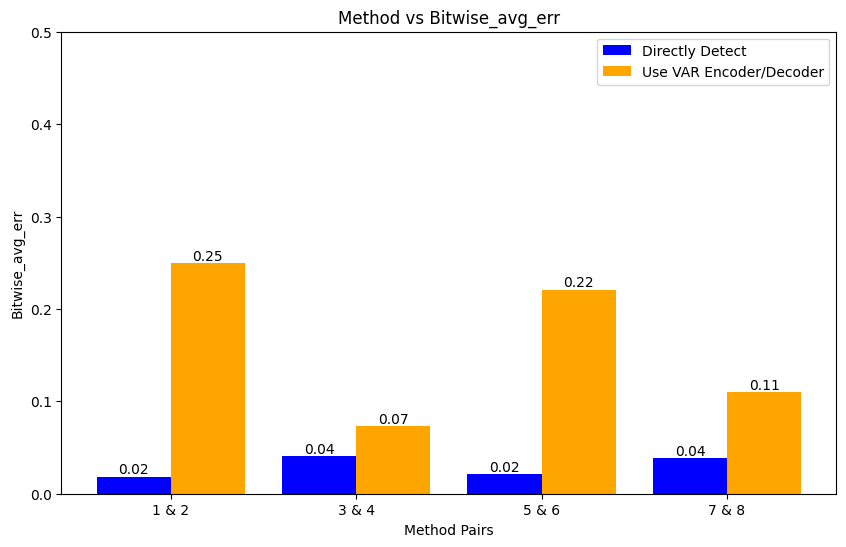

In [31]:
# 重新绘制带有数值标注的分组柱状图

# 重新导入必要的库
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 构造数据
data = {
    "Method": [1, 2, 3, 4, 5, 6, 7, 8],
    "Bitwise_a": [0.01825, 0.249708, 0.040291, 0.073333, 0.021416, 0.221000, 0.03825, 0.11],
    "Hidden-encoder/decoder": [
        "Directly Detect",
        "Use VAR Encoder/Decoder",
        "Directly Detect",
        "Use VAR Encoder/Decoder",
        "Directly Detect",
        "Use VAR Encoder/Decoder",
        "Directly Detect",
        "Use VAR Encoder/Decoder",
    ]
}

df = pd.DataFrame(data)

# 设置条形图的宽度
bar_width = 0.4
x = np.arange(len(df) // 2)  # 计算 x 轴的组位置

# 绘制柱状图，分组显示
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - bar_width / 2, df["Bitwise_a"][::2], width=bar_width, color="blue", label="Directly Detect")
bars2 = ax.bar(x + bar_width / 2, df["Bitwise_a"][1::2], width=bar_width, color="orange", label="Use VAR Encoder/Decoder")

# 添加数值标注（保留两位小数）
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize=10)

# 设置 x 轴刻度和标签
ax.set_xticks(x)
ax.set_xticklabels([f"{df['Method'][i]} & {df['Method'][i+1]}" for i in range(0, len(df), 2)])
ax.set_xlabel("Method Pairs")
ax.set_ylabel("Bitwise_avg_err")
ax.set_title("Method vs Bitwise_avg_err")

# 添加图例
ax.set_ylim(0, 0.5)
ax.legend()

# 显示图表
plt.show()




测试上述方法的performance，控制变量比较之前的方法，对上述进行对抗攻击测试robust

进行噪音的讨论，fhat中noise与image中的noise /robust,fhat中加noise如何加？

尝试组合之前的方法，比如说ft的，反正都是使用了同一个decoder训练，那就可以看看，叠加的效果是好是坏

在具体看看conv方法，是不是有梯度问题


Next

- 训练一个最基础的hidden，使用正常的image

- 训练一个只加 decoder var 的 hidden

- 添加noise layer 训练